## LDA (Latent Dirichlet Allocation) Topic modeling

In [1]:
import joblib as jbl
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pyLDAvis
import pandas as pd
from pyLDAvis.lda_model import prepare
from bertopic import BERTopic
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from gensim.models import Word2Vec
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\umap\__init__.py:36: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\pkg_resources\__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


### Loading the dataset, we need clean text

In [2]:
df = jbl.load("preprocessed_df.pkl")
clean_texts = df["clean_text"].values
clean_texts_concatted = [" ".join(sent) for sent in clean_texts]

### Fitting BOW vectorizer on full text

In [3]:
bow = CountVectorizer(lowercase=False, min_df=5, max_df=0.95, ngram_range=(1,1))
X = bow.fit_transform(clean_texts_concatted)
print("Vocabulary:", len(bow.get_feature_names_out()))

Vocabulary: 7073


### LDA

In [4]:
N_TOPICS = 10
lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42, max_iter=10, n_jobs=-1)
lda.fit(X)

LatentDirichletAllocation(n_jobs=-1, random_state=42)

### LDA: Top 15 words per topic

In [5]:
# Top 15 words per topic
terms = bow.get_feature_names_out()
topic_terms = []
for k, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[-15:][::-1]
    words = [terms[i] for i in top_idx]
    print(f'Topic {k}: ' + ', '.join(words))
    topic_terms.append(words)
lda_topics_df = pd.DataFrame({'topic_id': range(len(lda.components_)), 'top_words': [', '.join(ws) for ws in topic_terms]})
lda_topics_df.head()

Topic 0: food, rice, crop, also, farmer, seed, supply, blanket, family, product, clothing, election, production, non, item
Topic 1: water, health, disease, medical, team, well, also, hospital, system, shelter, facility, people, case, sanitation, drinking
Topic 2: hurricane, sandy, storm, santiago, time, day, house, power, go, make, back, even, love, get, good
Topic 3: government, international, disaster, country, community, relief, support, said, development, assistance, organization, humanitarian, local, group, national
Topic 4: help, need, please, like, food, would, people, know, find, information, water, thank, tent, give, get
Topic 5: water, rain, river, region, flood, area, rainfall, crop, weather, level, also, damage, flooding, cyclone, due
Topic 6: earthquake, haiti, http, message, note, rt, bit, important, ly, news, information, hit, help, understand, com
Topic 7: year, red, united, nation, cross, country, last, million, people, affected, area, refugee, drought, since, governme

,topic_id,top_words
0,0,"food, rice, crop, also, farmer, seed, supply, ..."
1,1,"water, health, disease, medical, team, well, a..."
2,2,"hurricane, sandy, storm, santiago, time, day, ..."
3,3,"government, international, disaster, country, ..."
4,4,"help, need, please, like, food, would, people,..."


### Visualisation

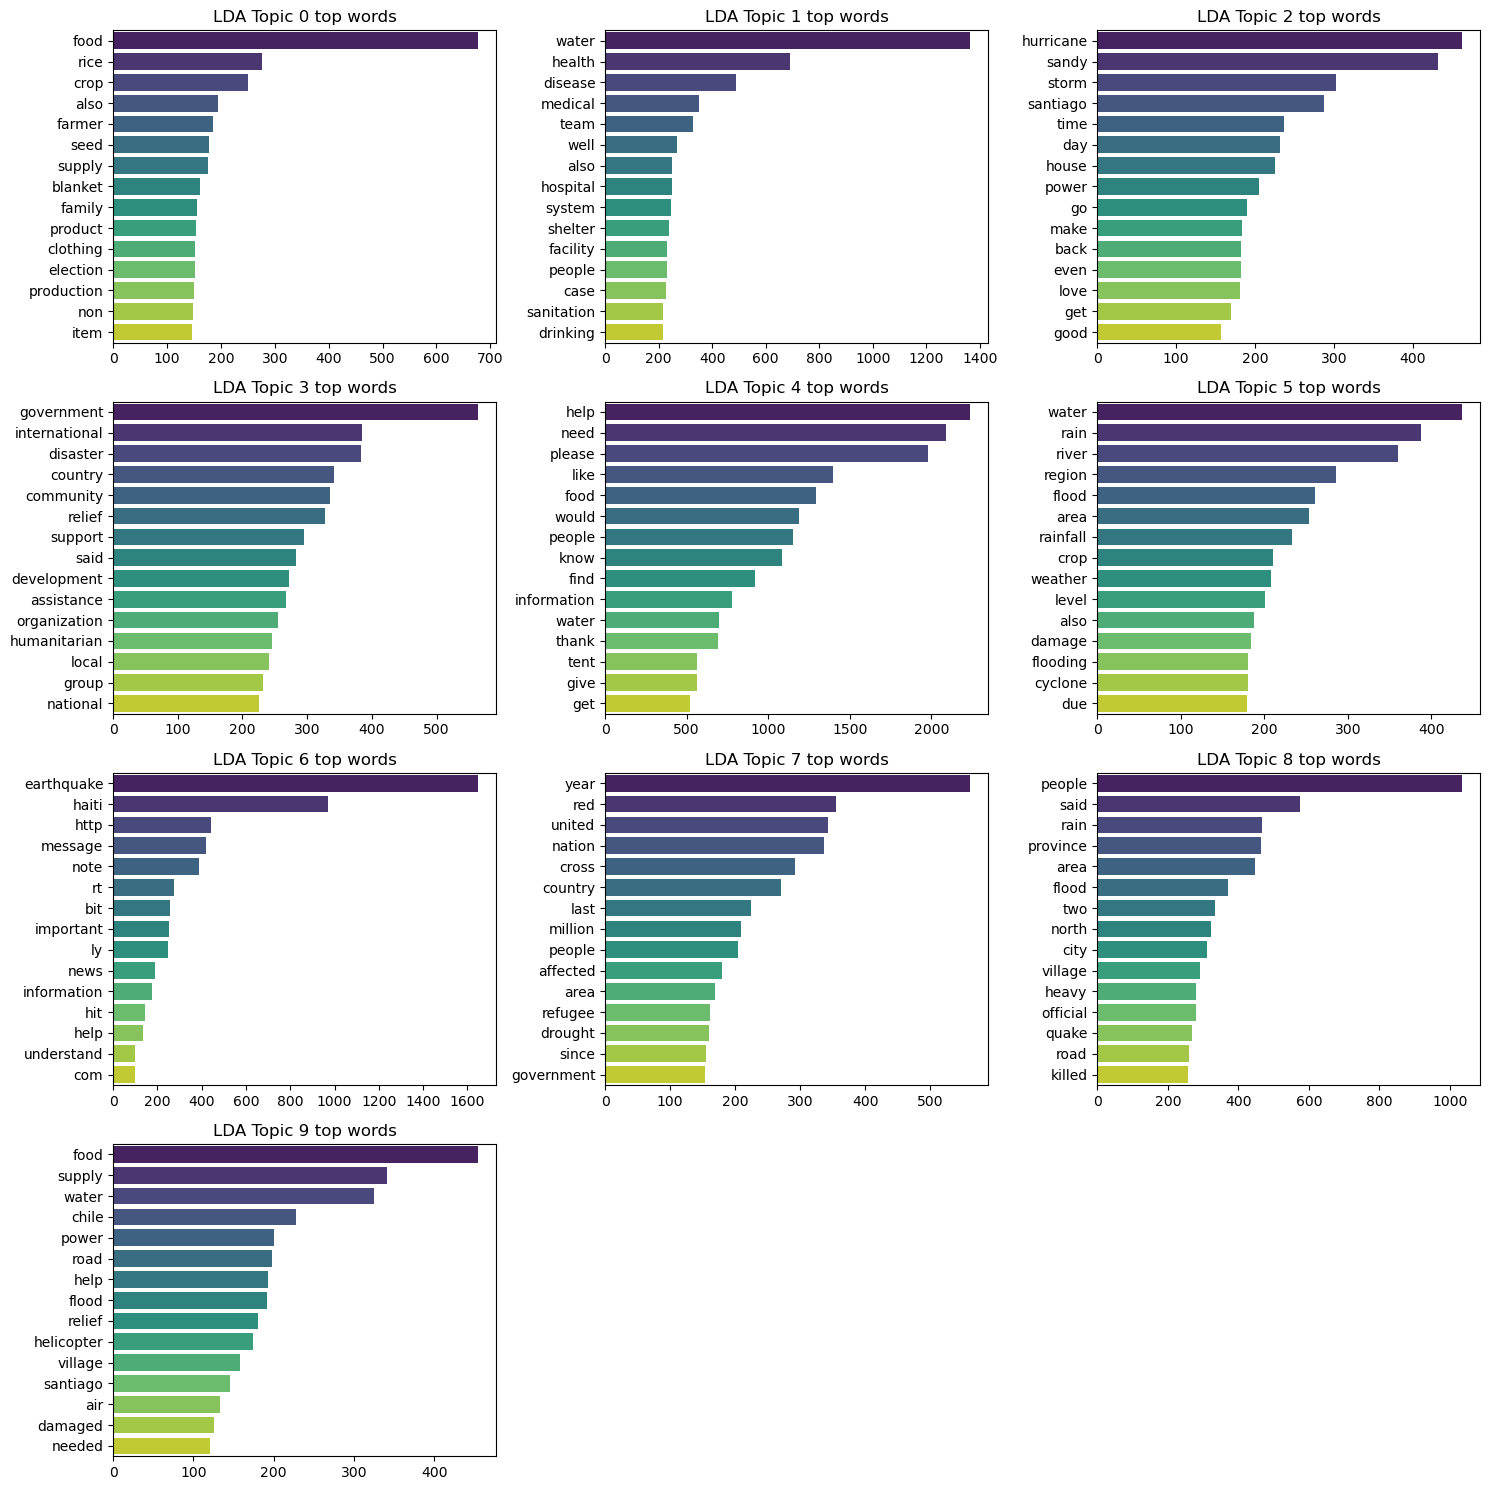

In [6]:
plt.figure(figsize=(15,15))
terms = bow.get_feature_names_out()
for i in range(N_TOPICS):
    plt.subplot(4,3,i+1)
    comp = lda.components_[i]
    top_idx = comp.argsort()[-15:][::-1]
    words = [terms[i] for i in top_idx]
    weights = [comp[i] for i in top_idx]
    sns.barplot(y=words, x=weights, orient="h", palette="viridis")
    plt.title(f'LDA Topic {i} top words')
plt.tight_layout()
plt.show()

### pyLDA interactive visualization

In [7]:
pyLDAvis.enable_notebook()
vis = prepare(lda, X, bow)
display(vis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.265158  0.086538       1        1  15.860385
8      0.059604 -0.142122       2        1  14.809012
3      0.131115  0.006306       3        1  12.440336
1      0.134250  0.106323       4        1  12.366195
5      0.166193 -0.110537       5        1   9.786028
7      0.139019 -0.104019       6        1   8.910828
2     -0.224958  0.045638       7        1   7.429844
0      0.095085  0.132862       8        1   7.258031
9     -0.009457  0.194435       9        1   6.613453
6     -0.225692 -0.215425      10        1   4.525887, topic_info=            Term         Freq        Total Category  logprob  loglift
1945  earthquake  1851.000000  1851.000000  Default  30.0000  30.0000
4686      please  1892.000000  1892.000000  Default  29.0000  29.0000
2819       haiti   960.000000   960.000000  Default  28.0000  28.0000
2916        help  2474.000000  2474.000000  Default  27.0000  27.0000
4192        need  2323.000000  2323.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3784       major    51.123521   291.018624  Topic10  -5.6584   1.3562
4686      please    60.291911  1892.719485  Topic10  -5.4935  -0.3512
4366         one    56.435259   992.765824  Topic10  -5.5596   0.2280
4220         new    53.369492   610.392325  Topic10  -5.6154   0.6585
4582      people    56.313886  2884.493686  Topic10  -5.5617  -0.8408

[737 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
77        3  0.008808     acute
77        4  0.827915     acute
77        6  0.158537     acute
109      10  0.944441    adress
125       3  0.943909  advocacy
...     ...       ...       ...
7042      7  0.788353      york
7071      3  0.094009        àö
7071      7  0.569585        àö
7071      9  0.337327        àö
7072      7  0.984884        àû

[1968 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 4, 2, 6, 8, 3, 1, 10, 7])

## BERTopic: topics, top words, and visualization

### Word2Vec Embeddings (TF-IDF weighted)

In [8]:
EMBED_DIM = 50
model = Word2Vec(clean_texts, window=5, vector_size=EMBED_DIM, epochs=10, sg=1, min_count=5)
# TF-IDF 
vectorizer = TfidfVectorizer(lowercase=False, min_df=5, max_df=0.95, ngram_range=(1,1))
X_tfidf = vectorizer.fit_transform(clean_texts_concatted)
vocab = vectorizer.get_feature_names_out()

# embedding matrix for vocabulary
dim = int(model.vector_size)
V = np.zeros((len(vocab), dim), dtype=np.float32)
in_vocab = 0
w2v_vocab = set(model.wv.key_to_index.keys())
for i, term in enumerate(vocab):
    if term in w2v_vocab:
        V[i] = model.wv[term]
        in_vocab += 1

# TF-IDF weighted average to get doc embeddings
doc_embeddings = X_tfidf.dot(V)
norm = np.linalg.norm(doc_embeddings, axis = 1, keepdims=True)
doc_embeddings = np.divide(doc_embeddings, norm, where= norm != 0)
doc_embeddings[np.argwhere(norm == 0)] = 0
print(f"Built doc_embeddings: shape={doc_embeddings.shape}, vocab={len(vocab)}, covered={in_vocab}")

Built doc_embeddings: shape=(26216, 50), vocab=7073, covered=7073


### BERTopic fit

Dimensionality reduction can be handled using PCA instead of UMAP, cluctering can be then done using Kmeans instead of HDBSCAN

In [12]:
topic_model = BERTopic(verbose=True, nr_topics=11, top_n_words=15)
topics, probs = topic_model.fit_transform(clean_texts_concatted, embeddings=doc_embeddings)
topic_info = topic_model.get_topic_info()
display(topic_info)

2025-11-02 05:13:59,076 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-02 05:14:12,459 - BERTopic - Dimensionality - Completed ✓
2025-11-02 05:14:12,461 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-02 05:14:14,268 - BERTopic - Cluster - Completed ✓
2025-11-02 05:14:14,269 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-02 05:14:15,287 - BERTopic - Representation - Completed ✓
2025-11-02 05:14:15,289 - BERTopic - Topic reduction - Reducing number of topics
2025-11-02 05:14:15,556 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-02 05:14:16,328 - BERTopic - Representation - Completed ✓
2025-11-02 05:14:16,337 - BERTopic - Topic reduction - Reduced number of topics from 126 to 11


,Topic,Count,Name,Representation,Representative_Docs
0,-1,6197,-1_help_please_need_like,"[help, please, need, like, know, find, food, p...","[need water food please help u help clercine, ..."
1,0,13623,0_water_people_area_said,"[water, people, area, said, also, flood, gover...",[cultivate small field extremely fertile lowla...
2,1,3192,1_need_please_help_like,"[need, please, help, like, would, au, port, pr...","[would like information please, need food wate..."
3,2,859,2_sandy_hurricane_storm_power,"[sandy, hurricane, storm, power, co, amp, tomo...","[hurricane, four hurricane sandy go hurricane ..."
4,3,696,3_earthquake_haiti_http_ly,"[earthquake, haiti, http, ly, bit, rt, com, ne...",[p haiti earthquake http bit ly okesh magnitud...
5,4,591,4_food_clothing_supply_baby,"[food, clothing, supply, baby, perishable, pro...",[want give non perishable food baby supply hyg...
6,5,400,5_santiago_chile_concepcion_rt,"[santiago, chile, concepcion, rt, earthquake, ...","[nncurry greeting santiago chile chile work, w..."
7,6,371,6_message_note_important_translate,"[message, note, important, translate, person, ...","[note message important, note important messag..."
8,7,135,7_kachipul_khan_village_flood,"[kachipul, khan, village, flood, pur, basti, p...",[village kachipul flood damaged alot crop home...
9,8,114,8_cruz_santa_elevation_constituci,"[cruz, santa, elevation, constituci, concepci,...",[interseismic strain accumulation measured gps...


### Interactive BERTopic visualization

In [13]:
# Plotly
fig = topic_model.visualize_topics()
fig.show()

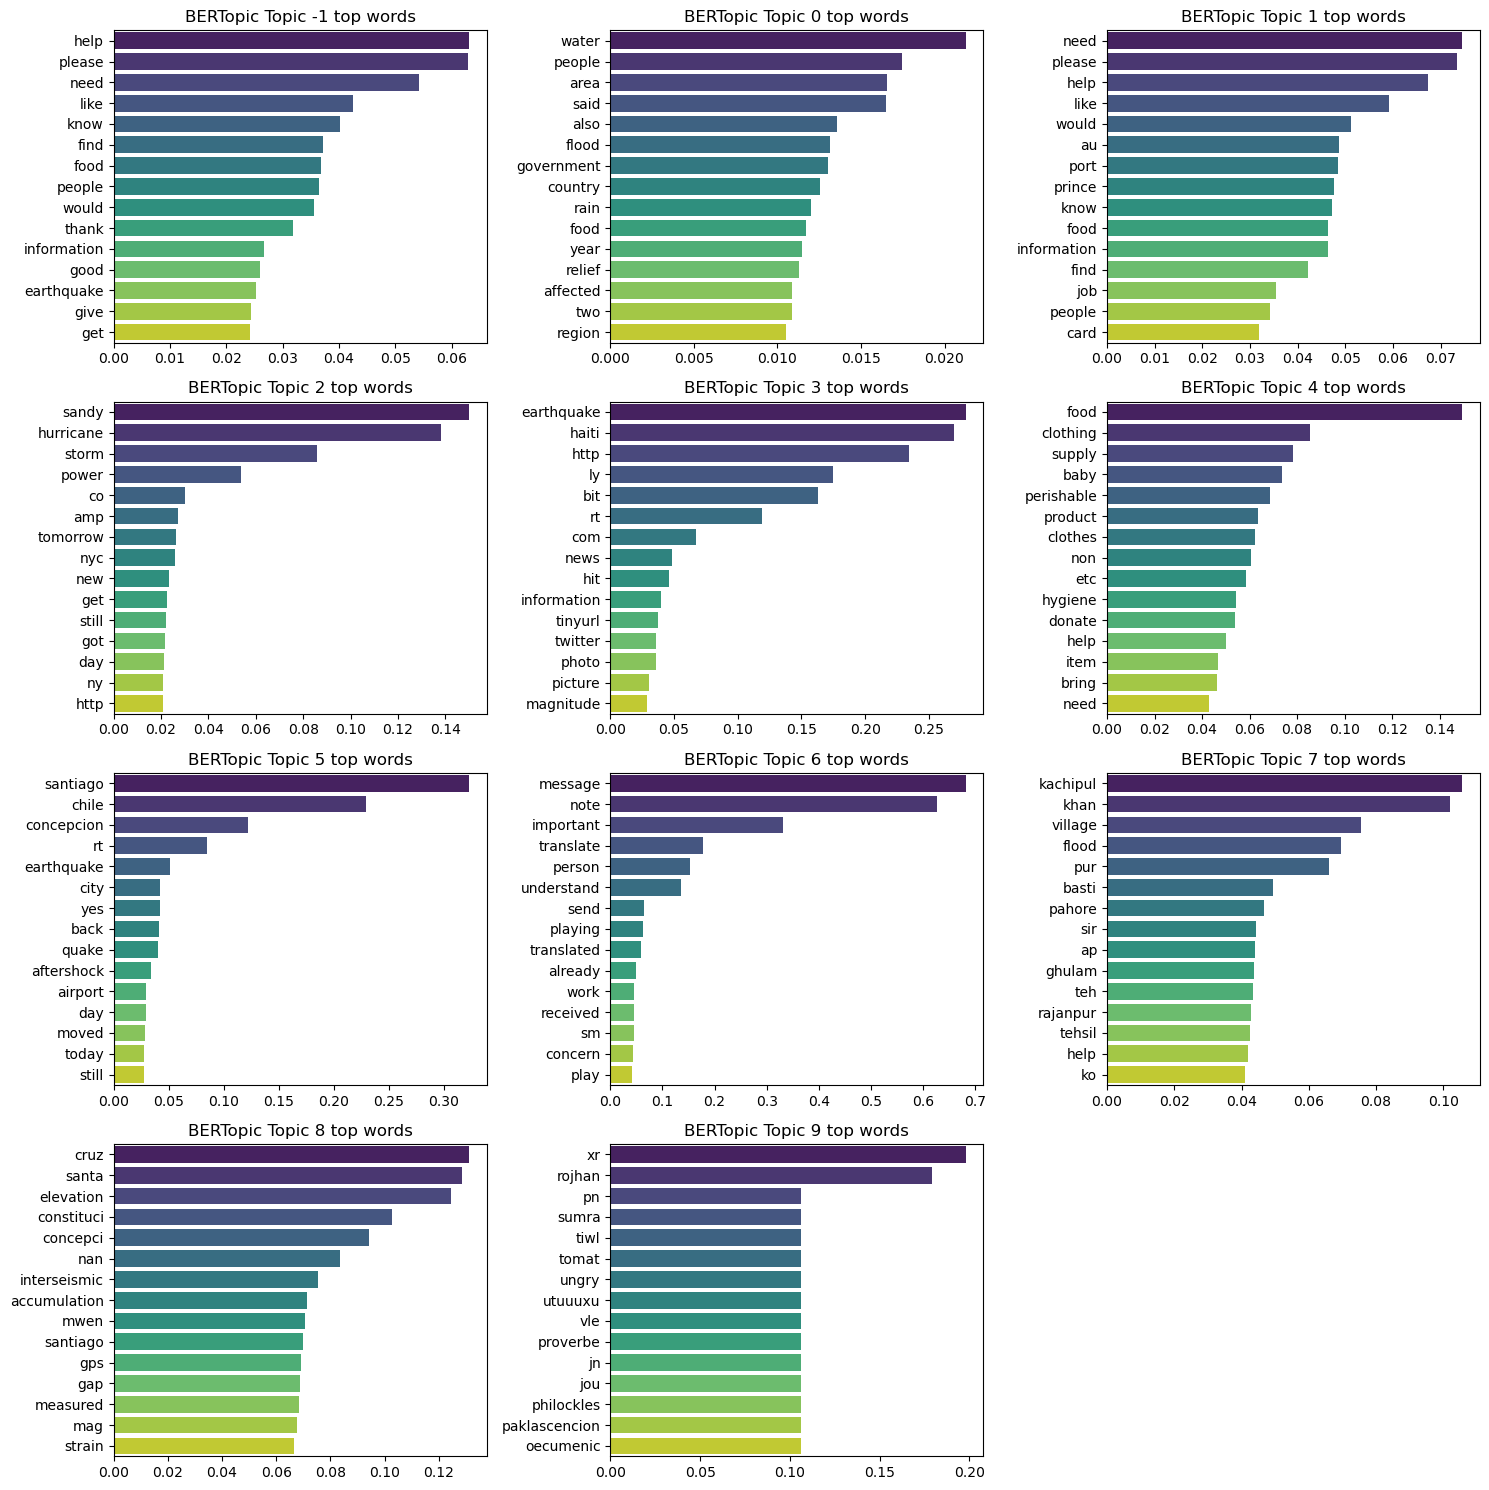

In [14]:
# Bar chart for a selected BERTopic topic's top words
plt.figure(figsize=(15,15))
i = 0
for tid in topic_model.get_topics().keys():
    plt.subplot(4,3,i+1)
    i+=1
    terms = topic_model.get_topic(tid)
    words = [w for w,_ in terms]
    weights = [wgt for _,wgt in terms]
    sns.barplot(y=words, x=weights, orient="h", palette="viridis")
    plt.title(f'BERTopic Topic {tid} top words')
plt.tight_layout()
plt.show()